In [1]:
from attacker_network import AttackerNetwork
from InstructDiffusionWrapper import InstructDiffusion
from prompt_tuning_attack.src.utils import open_image, display_image
from transformers import AutoImageProcessor, AutoModel
from torchvision import transforms
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

/users/eleves-b/2024/mattia.martino/env_diffusion/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
clip_model = clip.load("ViT-L/14", device="cuda")[0]

print("CLIP model loaded")

CLIP model loaded


In [3]:
instruct_pix2pix_model = InstructDiffusion(
    "InstructDiffusion/configs/instruct_diffusion.yaml",
    "InstructDiffusion/checkpoints/v1-5-pruned-emaonly-adaption-task-humanalign.ckpt"
    )

instruct_pix2pix_model.to(device)
instruct_pix2pix_model.eval()
instruct_pix2pix_model = instruct_pix2pix_model.half()

[2025-03-16 17:48:23,620] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -lcufile
collect2: error: ld returned 1 exit status
/users/eleves-b/2024/mattia.martino/adversarial-attack-diffusion/InstructDiffusion/stable_diffusion/ldm/modules/diffusionmodules/util.py:138: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32) # add this
/users/eleves-b/2024/mattia.martino/adversarial-attack-diffusion/InstructDiffusion/stable_diffusion/ldm/modules/diffusionmodules/util.py:150: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, *output_grads):
/users/eleves-b/2024/mattia.martino/env_diffusion/lib64/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, pleas

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.53 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /users/eleves-b/2024/mattia.martino/adversarial-attack-diffusion/InstructDiffusion/checkpoints/v1-5-pruned-emaonly-adaption-task-humanalign.ckpt with 12 missing and 0 unexpected keys
Missing Keys: ['betas', 'alphas_cumprod', 'alphas_cumprod_prev', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'log_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod', 'posterior_variance', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2']
Loading model from InstructDiffusion/checkpoints/v1-5-pruned-emaonly-adaption-task-humanalign.ckpt
['betas', 'alphas_cumprod', 'alphas_cumprod_prev', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'log_one_minus_alphas_cu

In [4]:
dinov2_model = AutoModel.from_pretrained("facebook/dinov2-small", torch_dtype=torch.float16).to(device)
dinov2_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")

print("DINOv2 model & preprocessor loaded!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


DINOv2 model & preprocessor loaded!


In [7]:
image = open_image("zebra.jpg")
transforms.ToTensor()(image).shape

torch.Size([3, 667, 1000])

In [7]:
image = open_image("zebra.jpg")
# display_image(image, title="Original Image")
pil_to_tensor = transforms.ToTensor()
image = pil_to_tensor(image).unsqueeze(0).to(device)
# image = torch.nn.functional.interpolate(image, size=(224, 224), mode="bilinear", align_corners=False)

In [4]:
output = instruct_pix2pix_model(image)

/users/eleves-b/2024/mattia.martino/env_diffusion/lib64/python3.9/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/users/eleves-b/2024/mattia.martino/env_diffusion/lib64/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [5]:
output.shape

torch.Size([1, 3, 256, 256])

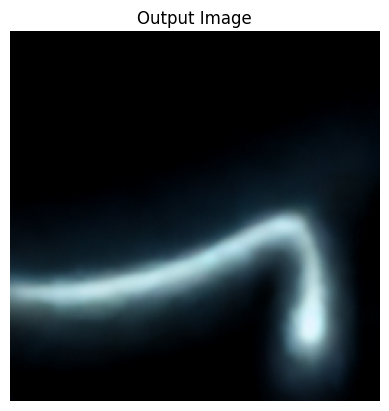

In [6]:
tensor_to_pil = transforms.ToPILImage()
output = tensor_to_pil(output.squeeze(0).cpu())
display_image(output, title="Output Image")

In [5]:
attacker = AttackerNetwork(
    clip_model=clip_model,
    pix2pix_model=instruct_pix2pix_model,
    dinov2_model=dinov2_model,
    dinov2_processor=dinov2_processor,
    device=device,
)

In [8]:
modified_feat, original_feat, modified_image = attacker(image)

/users/eleves-b/2024/mattia.martino/env_diffusion/lib64/python3.9/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/users/eleves-b/2024/mattia.martino/env_diffusion/lib64/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [11]:
print(modified_feat.shape)
print(original_feat.shape)


torch.Size([1, 384])
torch.Size([1, 384])


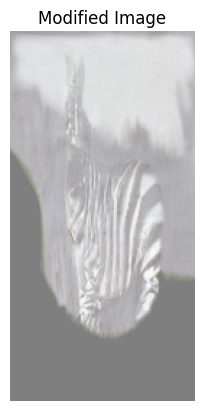

In [10]:
display_image(modified_image, title="Modified Image")

In [14]:
total_params = 0
trainable_params = 0
        
        # Count parameters in all modules
for name, module in attacker.named_modules():
    for param in module.parameters(recurse=False):
        total_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
                    
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} total parameters")
print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")


Trainable parameters: 11,520 / 1,515,931,436 total parameters
Percentage of trainable parameters: 0.00%
